In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34


## Step 1. 도입전 기본 처리

### 문제 1. 구글 drive와 colab 연동하기

In [2]:
# https://onedrive.live.com/?authkey=%21ADkS4V32BUmspOg&cid=F5111408123B1D9C&id=F5111408123B1D9C%2115035&parId=F5111408123B1D9C%2115033&action=locate

### 문제 2. pfcn 데이터 살펴보기

In [2]:
# 데이터를 np array로 training에서 사람 이미지 한장을 불러오는 코드를 작성해주세요. (x로 변수 대입)

import imageio

x = imageio.imread('datasets/pfcn_original/training/00001.png')

### 문제 3. x와 shape을 출력해보세요.

In [3]:
# 데이터의 크기를 shape 함수를 통해 출력해주세요.

print(x.shape)

(800, 600, 3)


### 문제 4. x를 plt를 통하여 출력하세요.

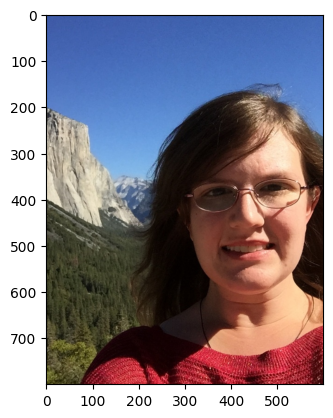

In [4]:
# x를 plt를 이용하여 출력하는 코드를 작성해보세요.
plt.imshow(x)
plt.show()

### 문제 5. (800, 600)의 의미지는 colab에서 돌리기에 너무 큽니다. (100, 75)로 이미지를 줄여보세요

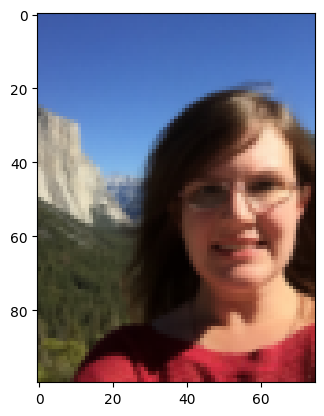

In [5]:
# x를 (800, 600, 3) -> (100, 75, 3)로 줄이고 plt에서 확인하는 코드를 작성하세요.

from skimage.transform import resize

plt.imshow(resize(x, output_shape=(100, 75, 3)))
plt.show()

### 문제 6. pfcn_small.npz 데이터에서 학습, 테스트 데이터를 로드하세요.

In [6]:
# pfcn_small.npz에서 train_images, test_images를 np array로 로드하세요.

datasets = np.load('datasets/pfcn_small.npz')
print(list(datasets.keys()))
train_images, test_images = datasets['train_images'], datasets['test_images']

['train_images', 'test_images', 'train_mattes', 'test_mattes']


### 문제 7. train_images에서 0이 아닌 값들을 출력해보세요.

In [7]:
# 하나의 이미지에 대한 모든 0이 아닌 값을 출력하는 코드를 작성하세요.

print(train_images[train_images != 0][:10])

[0.23627451 0.34803922 0.64705882 0.24509804 0.35686275 0.65588235
 0.25490196 0.36470588 0.66470588 0.2372549 ]


### 문제 8. train_images의 dtype을 출력해보세요.

In [8]:
# dtype을 이용하여 이미지의 np array type을 확인해보세요.
print(train_images.dtype)

float64


## Step 2. 전처리

### 문제 9. train/test 이미지 데이터의 범위 확인

In [9]:
#  test_images shape과 dtype, 0이 아닌 숫자를 출력하는 코드를 작성하세요.

print(train_images.shape, train_images.dtype, train_images[train_images !=0][:5])
print(test_images.shape, test_images.dtype, test_images[test_images !=0][:5])

(1700, 100, 75, 3) float64 [0.23627451 0.34803922 0.64705882 0.24509804 0.35686275]
(300, 100, 75, 3) float64 [0.50980392 0.64117647 0.64313725 0.51568627 0.64705882]


### 문제 10. train/test 이미지 데이터의 최소/최대값을 출력

In [10]:
# train/test 전체 데이터에서 min, max를 출력하는 코드를 작성하세요.

print(train_images.max(), train_images.min())
print(test_images.max(), test_images.min())

1.0 0.0
1.0 0.0


### 문제 11. train_images와 test_images로 흑백인 train_gray_images, test_gray_images를 생성하세요.

(1700, 100, 75, 1)


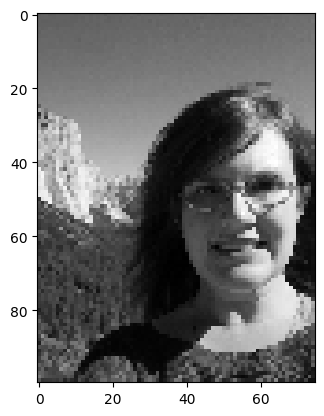

In [11]:
# train_images와 test_images로 흑백인 train_gray_images, test_gray_images를 생성하세요.
from skimage import color

train_gray_images = np.array([color.rgb2gray(img).reshape(100, 75, 1) for img in train_images])
test_gray_images = np.array([color.rgb2gray(img).reshape(100, 75, 1) for img in test_images])
print(train_gray_images.shape)
plt.imshow(train_gray_images[0], cmap = 'gray')
plt.show()

## Step 3. 시각화 방법

### 문제 12. train_image의 이미지를 5장 획득하여 (5, 100, 75, 3)의 shape을 출력하세요.

In [12]:
# (배치, 100, 75, 3)인 train_images에서 (5, 100, 75, 3)을 획득하는 코드를 작성하세요.

print(train_images[:5].shape)

(5, 100, 75, 3)


### 문제 13. 획득한 5장의 의미지를 (100, 75 * 5, 3)의 shape으로 변경해보세요.

In [13]:
# np.hstack은 height 방향의 배열을 풀어서 width 방향으로 연결해줍니다.
# 해당 기능을 쓰면 (height, image_height, image_width, color)의 shape을 (image_height, image_width * height, color)으로 바꿔 줄 수 있습니다.
# 코드를 작성해보세요.

print(np.hstack(train_images[:5]).shape)

(100, 375, 3)


### 문제 14. (100, 375, 3)이 된 tensor를 plt로 출력해보세요.

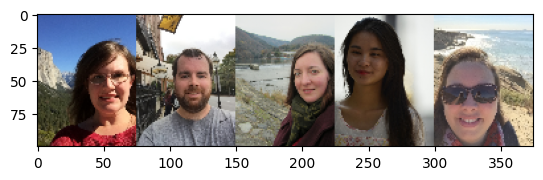

In [14]:
# (100, 375, 3)의 이미지를 plt로 출력해보세요.

plt.imshow(train_images[:5].transpose(1, 0, 2, 3).reshape(100, -1, 3))
plt.show()

### 문제 15. gray도 (100, 375)으로 plt로 출력해보세요.

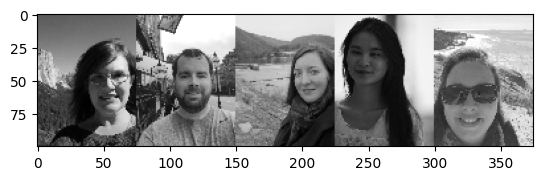

In [15]:
# (28, 140, 1)의 이미지를 plt로 출력해보세요.

plt.imshow(train_gray_images[:5].transpose(1, 0, 2, 3).reshape(100, -1, 1), cmap = 'gray')
plt.show()

## Step 4. 흑백 -> 칼라 모델링

### 문제 16. 흑백 이미지를 칼라로 변환하는 모델을 작성하세요.

In [17]:
# input (100, 75, 1), output (100, 75, 3)을 처리할 수 있는 모래시계 모양의 모델을 작성하세요.
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, MaxPool2D
from tensorflow.keras.layers import Reshape, Dropout, BatchNormalization, Activation, concatenate
from tensorflow.keras.models import Model

def conv2d_block(x, channel):
    x = Conv2D(filters = channel, kernel_size = 3, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters = channel, kernel_size = 3, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

def unet_color():
    inputs = Input(shape = (100, 75, 1))
    
    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D(pool_size = 2)(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D(pool_size = 2)(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv2d_block(p2, 64)
    p3 = MaxPool2D(pool_size = 2)(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv2d_block(p3, 128)
    p4 = MaxPool2D(pool_size = 2)(c4)
    p4 = Dropout(0.1)(p4)
    
    c5 = conv2d_block(p4, 256)

    u6 = Conv2DTranspose(128, kernel_size = 2, strides = 2, padding = 'valid', output_padding = (0, 1))(c5)
    u6 = concatenate([c4, u6])
    u6 = Dropout(0.1)(u6)
    c6 = conv2d_block(u6, 128)

    u7 = Conv2DTranspose(64, kernel_size = 2, strides = 2, padding = 'valid', output_padding = (1, 0))(c6)
    u7 = concatenate([c3, u7])
    u7 = Dropout(0.1)(u7)
    c7 = conv2d_block(u7, 64)

    u8 = Conv2DTranspose(32, kernel_size = 2, strides = 2, padding = 'valid', output_padding = (0, 1))(c7)
    u8 = concatenate([c2, u8])
    u8 = Dropout(0.1)(u8)
    c8 = conv2d_block(u8, 32)

    u9 = Conv2DTranspose(16, kernel_size = 2, strides = 2, padding = 'valid', output_padding = (0, 1))(c8)
    u9 = concatenate([c1, u9])
    u9 = Dropout(0.1)(u9)
    c9 = conv2d_block(u9, 16)

    outputs = Conv2D(3, kernel_size = 1, activation = 'sigmoid')(c9)
    
    model = Model(inputs, outputs)
    return model

### 문제 17. 모델을 할당 받고 서머리를 출력해보세요.

In [18]:
# unet_color() 모델을 할당 받고 서머리를 출력하는 코드를 작성하세요.

model = unet_color()
model.summary()

2023-10-17 18:54:41.635446: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-10-17 18:54:41.635468: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-10-17 18:54:41.635473: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-10-17 18:54:41.635502: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-17 18:54:41.635519: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 75, 1)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 100, 75, 16)          160       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 100, 75, 16)          64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 100, 75, 16)          0         ['batch_normalization[0][0

### 문제 18. 만든 모델에 로스와 옵티마이저, 메트릭을 설정하세요.

In [19]:
# 만든 모델에 loss는 mse, optimizer는 adam 매트릭은 accuracy으로 설정하는 코드를 작성하세요.
model.compile(loss = 'mse', optimizer='adam', metrics=['accuracy'])

### 문제 19. 만든 모델에 train_gray_images, train_images를 학습시켜 보세요.

In [20]:
# train_gray_images 학습시키고 5 epochs을 돌리고 그 진행 사항을 hist에 저장하는 코드를 작성하세요.
hist = model.fit(
    train_gray_images,
    train_images,
    validation_data = (
        test_gray_images,
        test_images
    ),
    epochs = 53,
    verbose = 1
)

Epoch 1/53


2023-10-17 18:54:46.856331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - ETA: 0s - loss: 0.0337 - accuracy: 0.6610

2023-10-17 18:55:11.868908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 32s 335ms/step - loss: 0.0337 - accuracy: 0.6610 - val_loss: 0.0691 - val_accuracy: 0.6875
Epoch 2/53
54/54 [==============================] - 3s 62ms/step - loss: 0.0144 - accuracy: 0.6766 - val_loss: 0.0723 - val_accuracy: 0.6892
Epoch 3/53
54/54 [==============================] - 3s 61ms/step - loss: 0.0105 - accuracy: 0.6702 - val_loss: 0.0666 - val_accuracy: 0.6892
Epoch 4/53
54/54 [==============================] - 3s 62ms/step - loss: 0.0089 - accuracy: 0.6583 - val_loss: 0.0567 - val_accuracy: 0.6892
Epoch 5/53
54/54 [==============================] - 3s 62ms/step - loss: 0.0082 - accuracy: 0.6487 - val_loss: 0.0433 - val_accuracy: 0.6685
Epoch 6/53
54/54 [==============================] - 3s 61ms/step - loss: 0.0080 - accuracy: 0.6460 - val_loss: 0.0323 - val_accuracy: 0.5909
Epoch 7/53
54/54 [==============================] - 3s 60ms/step - loss: 0.0078 - accuracy: 0.6447 - val_loss: 0.0243 - val_accuracy: 0.6034
Epoch 8/53
54/54 [====

### 문제 20. 학습 진행 사항을 plt으로 출력하세요.

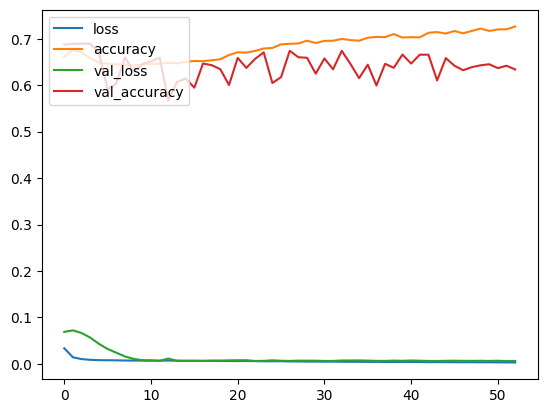

In [21]:
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드를 작성하세요.
list(hist.history.keys())

plt.plot(hist.history['loss'], label = 'loss')
plt.plot(hist.history['accuracy'], label = 'accuracy')
plt.plot(hist.history['val_loss'], label = 'val_loss')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
plt.legend(loc = 'upper left')
plt.show()


## Step 5. 칼라 모델 결과 확인

### 문제 21. 완성된 모델에서 test_gray_images를 1장 넣고 결과를 res 변수에 저정하세요.

In [22]:
# 모델에 test_gray_images 중 1장을 넣고 결과를 받는 코드를 작성하세요.

res = model.predict(test_gray_images[1:2])
print(res.shape)

2023-10-17 18:58:06.263016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step
(1, 100, 75, 3)


### 문제 22. res와 test_images[1]를 width 방향으로 결합하여 plt로 출력하세요.

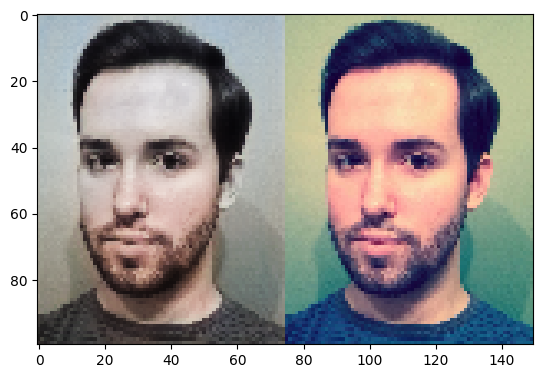

In [23]:
# res와 test_images[1]를 width 방향으로 결합하여 (100, 75 * 3, 3) 의 이미지를 만들어 plt로 출력하는 코드를 작성하세요.
plt.imshow(np.concatenate([res[0], test_images[1]], axis = 1))
plt.show()

### 문제 23. 5장의 test_gray_images를 모델에 넣은 뒤 결과를 문제 29 방식으로 비교하세요.

1/1 [==============================] - 2s 2s/step
(200, 375, 3)


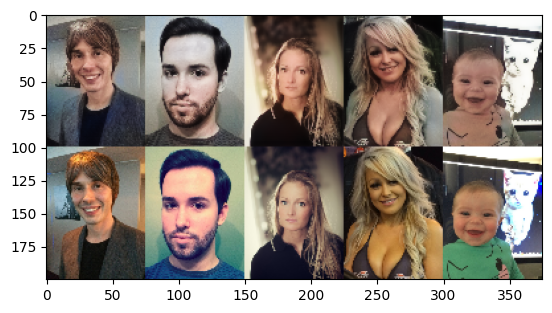

In [24]:
# 5장의 이미지를 모델에 넣고 결과를 29번과 같은 방식으로 비교하는 코드를 작성하세요.
res_five = model.predict(test_gray_images[:5])

print(np.concatenate([res_five, test_images[:5]], axis = 1).transpose(1, 0, 2, 3).reshape(200, -1, 3).shape)
plt.imshow(np.concatenate([res_five, test_images[:5]], axis = 1).transpose(1, 0, 2, 3).reshape(200, -1, 3))
plt.show()

## Step 6. lab 칼라 모델링

### 문제 24. rgb 칼라를 lab 칼라로 바꿔보세요. (위의 color 모델이 잘못된 것은 아님)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(100, 75, 3)


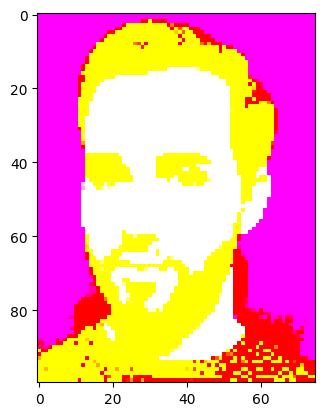

(1700, 100, 75, 3)


In [18]:
# rgb2lab을 이용하여 rgb 칼라를 lab 칼라로 바꾸는 코드를 작성하세요.

print(color.rgb2lab(test_images[1]).shape)
plt.imshow(color.rgb2lab(test_images[1]))
plt.show()

train_lab_images = np.array([color.rgb2lab(img) for img in train_images])
test_lab_images = np.array([color.rgb2lab(img) for img in test_images])

print(train_lab_images.shape)


### 문제 25. lab 칼라 이미지를 채널별로 최대, 최소 값을 출력해보세요.

In [19]:
# lab 칼라 이미지를 채널별로 최대, 최소 값을 출력하는 코드를 작성하세요.

print(train_lab_images[..., 0].min(), train_lab_images[..., 0].max()) # (1700, 100, 75, 0) l
print(train_lab_images[..., 1].min(), train_lab_images[..., 1].max()) # (1700, 100, 75, 1) a
print(train_lab_images[..., 2].min(), train_lab_images[..., 2].max()) # (1700, 100, 75, 2) b


0.0 100.0
-78.53736435567538 86.20773183914271
-91.97308466277423 93.80664030542576


### 문제 26. lab 칼라는 채널별 최대값을 [0-100, +-128, +-128]로 가지고 있습니다. 0-1 노말라이즈 하세요.

In [27]:
# lab 칼라를 노말라이즈 하는 코드를 작성하세요.
a = train_lab_images + [0, 128, 128]
# (0 ~ 100) + 0 => 0 ~ 100
# (-128 ~ 127) + 128 => 0 ~ 255
# (-128 ~ 127) + 128 => 0 ~ 255

print(a[..., 0].min(), a[..., 0].max())
print(a[..., 1].min(), a[..., 1].max())
print(a[..., 2].min(), a[..., 2].max())

b = a / [100., 255., 255.]
print(b[..., 0].min(), b[..., 0].max())
print(b[..., 1].min(), b[..., 1].max())
print(b[..., 2].min(), b[..., 2].max())

0.0 100.0
49.46263564432462 214.2077318391427
36.02691533722577 221.80664030542576
0.0 1.0
0.19397112017382204 0.8400303209378145
0.14128202093029715 0.8698299619820618


In [28]:
train_lab_images = (train_lab_images + [0, 128, 128]) / [100., 255., 255.]
test_lab_images = (test_lab_images + [0, 128, 128]) / [100., 255., 255.]

print(train_lab_images[..., 0].min(), train_lab_images[..., 0].max())
print(train_lab_images[..., 1].min(), train_lab_images[..., 1].max())
print(train_lab_images[..., 2].min(), train_lab_images[..., 2].max())

print(test_lab_images[..., 0].min(), test_lab_images[..., 0].max())
print(test_lab_images[..., 1].min(), test_lab_images[..., 1].max())
print(test_lab_images[..., 2].min(), test_lab_images[..., 2].max())

0.0 1.0
0.19397112017382204 0.8400303209378145
0.14128202093029715 0.8698299619820618
0.0 1.0
0.21236785542806763 0.831096115007859
0.08024923368351215 0.8597514769539841


### 문제 27. lab 칼라의 이미지 하나를 고르고 첫번째 채널을 plt으로 출력해보세요.


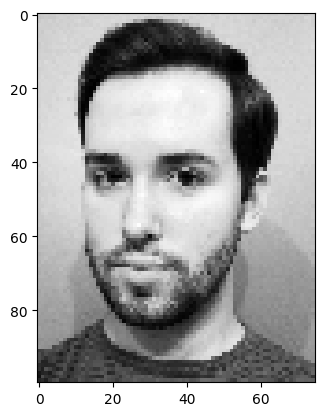

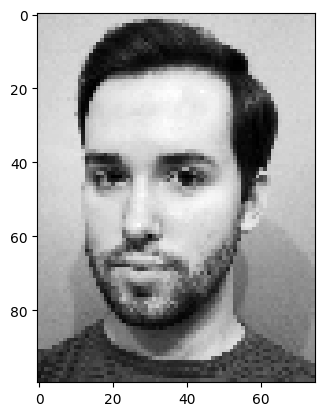

In [29]:
# lab 칼라 이미지의 첫번째 채널을 plt로 출력하는 코드를 작성하세요.
plt.imshow(test_lab_images[1, ..., 0], cmap='gray')
plt.show()

plt.imshow(test_gray_images[1, ..., 0], cmap='gray')
plt.show()

# grayscale x => r?, g?, ?b?   ### 3개의 채널을 예측해야함
# L x =>         a ?, b?  (L은 이미 가지고 있다(L = 흑백 이미지)) ## 2개의 채널만 예측하면 됨

# model1(grayscale x) -> r ? g ? b
# model2(L x) -> a?b? => Lx + a?b? -> rgb

### 문제 28. lab 칼라 첫번째 채널로 나머지 2채널을 예측하는 모델을 작성하세요.

In [30]:
# input (100, 75, 1), output (100, 75, 2)을 처리할 수 있는 모래시계 모양의 모델을 작성하세요.

from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, MaxPool2D
from tensorflow.keras.layers import Reshape, Dropout, BatchNormalization, Activation, concatenate
from tensorflow.keras.models import Model

def conv2d_block(x, channel):
    x = Conv2D(filters = channel, kernel_size = 3, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters = channel, kernel_size = 3, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

def unet_lab():
    inputs = Input(shape = (100, 75, 1))
    
    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D(pool_size = 2)(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D(pool_size = 2)(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv2d_block(p2, 64)
    p3 = MaxPool2D(pool_size = 2)(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv2d_block(p3, 128)
    p4 = MaxPool2D(pool_size = 2)(c4)
    p4 = Dropout(0.1)(p4)
    
    c5 = conv2d_block(p4, 256)

    u6 = Conv2DTranspose(128, kernel_size = 2, strides = 2, padding = 'valid', output_padding = (0, 1))(c5)
    u6 = concatenate([c4, u6])
    u6 = Dropout(0.1)(u6)
    c6 = conv2d_block(u6, 128)

    u7 = Conv2DTranspose(64, kernel_size = 2, strides = 2, padding = 'valid', output_padding = (1, 0))(c6)
    u7 = concatenate([c3, u7])
    u7 = Dropout(0.1)(u7)
    c7 = conv2d_block(u7, 64)

    u8 = Conv2DTranspose(32, kernel_size = 2, strides = 2, padding = 'valid', output_padding = (0, 1))(c7)
    u8 = concatenate([c2, u8])
    u8 = Dropout(0.1)(u8)
    c8 = conv2d_block(u8, 32)

    u9 = Conv2DTranspose(16, kernel_size = 2, strides = 2, padding = 'valid', output_padding = (0, 1))(c8)
    u9 = concatenate([c1, u9])
    u9 = Dropout(0.1)(u9)
    c9 = conv2d_block(u9, 16)

    outputs = Conv2D(2, kernel_size = 1, activation = 'sigmoid')(c9)
    
    model = Model(inputs, outputs)
    return model

### 문제 29. 모델을 할당 받고 서머리를 출력해보세요.

In [31]:
# unet_lab() 모델을 할당 받고 서머리를 출력하는 코드를 작성하세요.

model_lab = unet_lab()
model_lab.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 100, 75, 1)]         0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 100, 75, 16)          160       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_18 (Ba  (None, 100, 75, 16)          64        ['conv2d_19[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_18 (Activation)  (None, 100, 75, 16)          0         ['batch_normalization_18

### 문제 30. 만든 모델에 로스와 옵티마이저, 메트릭을 설정하세요.

In [32]:
# 만든 모델에 loss는 mae, optimizer는 adam 매트릭은 accuracy으로 설정하는 코드를 작성하세요.

model_lab.compile(loss = 'mae', optimizer='adam', metrics = 'accuracy')

### 문제 31. 만든 모델에 train_lab_images[...,0], train_lab_images[...,1:]를 학습시켜 보세요.

In [33]:
# train_lab_images[...,0], 학습시키고 50 epochs을 돌리고 그 진행 사항을 hist에 저장하는 코드를 작성하세요.

lab_hist = model_lab.fit(
    train_lab_images[..., 0:1],
    train_lab_images[..., 1:],
    validation_data = (
        test_lab_images[..., 0:1],
        test_lab_images[..., 1:]
    ),
    epochs = 53,
    verbose = 1
)

Epoch 1/53


2023-10-17 18:58:14.713381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - ETA: 0s - loss: 0.0545 - accuracy: 0.5585

2023-10-17 18:58:40.273078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 32s 335ms/step - loss: 0.0545 - accuracy: 0.5585 - val_loss: 0.0368 - val_accuracy: 0.4999
Epoch 2/53
54/54 [==============================] - 3s 60ms/step - loss: 0.0362 - accuracy: 0.5977 - val_loss: 0.0402 - val_accuracy: 0.5938
Epoch 3/53
54/54 [==============================] - 3s 60ms/step - loss: 0.0360 - accuracy: 0.6075 - val_loss: 0.0414 - val_accuracy: 0.5969
Epoch 4/53
54/54 [==============================] - 3s 60ms/step - loss: 0.0344 - accuracy: 0.6033 - val_loss: 0.0381 - val_accuracy: 0.5758
Epoch 5/53
54/54 [==============================] - 3s 60ms/step - loss: 0.0337 - accuracy: 0.6103 - val_loss: 0.0439 - val_accuracy: 0.5303
Epoch 6/53
54/54 [==============================] - 3s 60ms/step - loss: 0.0331 - accuracy: 0.6093 - val_loss: 0.0404 - val_accuracy: 0.5713
Epoch 7/53
54/54 [==============================] - 3s 60ms/step - loss: 0.0328 - accuracy: 0.6143 - val_loss: 0.0407 - val_accuracy: 0.5795
Epoch 8/53
54/54 [====

### 문제 32. 학습 진행 사항을 plt으로 출력하세요.

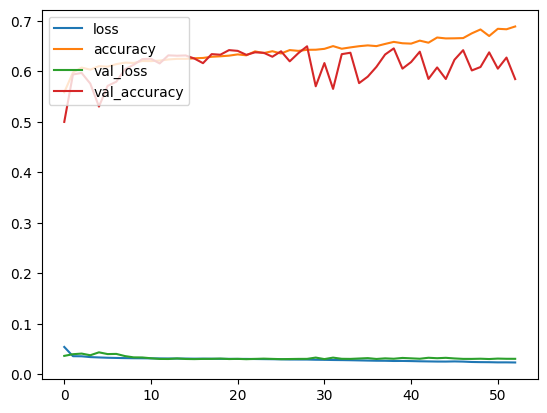

In [34]:
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드를 작성하세요.

plt.plot(lab_hist.history['loss'], label = 'loss')
plt.plot(lab_hist.history['accuracy'], label = 'accuracy')
plt.plot(lab_hist.history['val_loss'], label = 'val_loss')
plt.plot(lab_hist.history['val_accuracy'], label = 'val_accuracy')
plt.legend(loc = 'upper left')
plt.show()

## Step 7. lab 칼라 모델 결과 확인

### 문제 33. 완성된 모델에서 흑백이미지 1장 넣고 결과를 res 변수에 저정하세요.

In [35]:
# 모델에 흑백이미지 중 1장을 넣고 결과를 받는 코드를 작성하세요.

res_lab = model_lab.predict(test_lab_images[1:2][..., 0:1])
print(res_lab.shape)


2023-10-17 19:01:35.129339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 3s 3s/step
(1, 100, 75, 2)


### 문제 34. res와 test_lab_images[...,1:]를 width 방향으로 결합하여 plt로 출력하세요.

In [36]:
# res와 test_images[1]를 width 방향으로 결합하여 (100, 75 * 3, 3) 의 이미지를 만들어 plt로 출력하는 코드를 작성하세요.

test_lab_images[1:2][...,0:1].shape, res_lab.shape



# plt.imshow(np.concatenate([res[0], test_images[1]], axis = 1))
# plt.show()

((1, 100, 75, 1), (1, 100, 75, 2))

In [37]:
def l2rgb(L):
    pred_ab = model_lab.predict(np.expand_dims(L, 0))
    pred_img = np.zeros(shape = (100, 75, 3))

    pred_img[:, :, 0] = L.reshape((100, 75))
    pred_img[:, :, 1:] = pred_ab[0]

    pred_lab = (pred_img * [100, 255, 255]) - [0, 128, 128]

    rgb_img = color.lab2rgb(pred_lab)

    return rgb_img

1/1 [==============================] - 0s 21ms/step


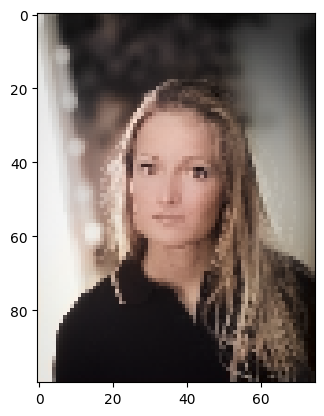

In [38]:
plt.imshow(l2rgb(test_lab_images[2][...,0:1]))
plt.show()

### 문제 35. 5장의 test_lab_images를 모델에 넣은 뒤 결과를 문제 29 방식으로 비교하세요.

1/1 [==============================] - 0s 19ms/step


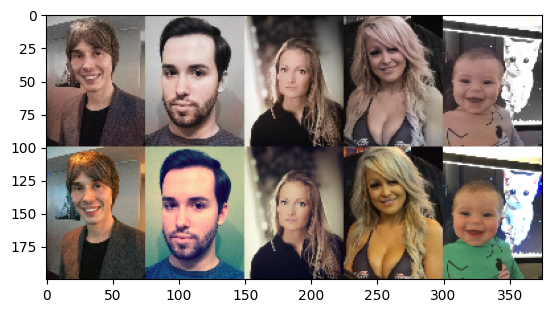

In [39]:
# 5장의 이미지를 모델에 넣고 결과를 29번과 같은 방식으로 비교하는 코드를 작성하세요.
five_rgb_img = np.array([l2rgb(img) for img in test_lab_images[:5][..., 0:1]])

plt.imshow(np.concatenate([five_rgb_img, test_images[:5]], axis = 1).transpose(1, 0, 2, 3).reshape(200, -1, 3))
plt.show()

In [40]:
five1 = model.predict(test_gray_images[:5])


1/1 [==============================] - 0s 32ms/step


In [41]:
five2 = np.array([l2rgb(img) for img in test_lab_images[:5][..., 0:1]])



1/1 [==============================] - 0s 19ms/step


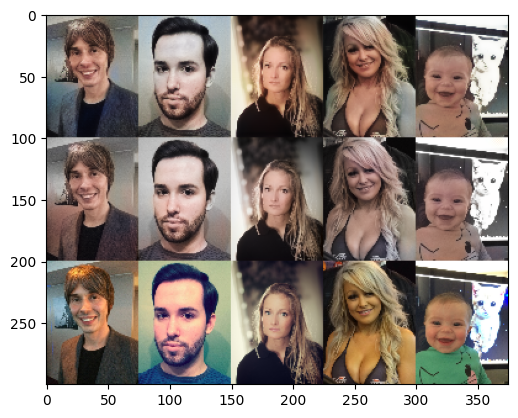

In [42]:
plt.imshow(np.concatenate([five1, five2, test_images[:5]], axis = 1).transpose(1, 0, 2, 3).reshape(300, -1, 3))
plt.show()

## Step 8. 모델 저장 및 로드, 다운

### 문제 36. 모델을 저장하세요.

In [43]:
# 모델을 저장하는 코드를 작성하세요.

model_lab.save('model/part2_ch04.h5')


### 문제 37. 모델 파일을 새로운 모델에 로드하세요.

In [44]:
# 모델을 로드하는 코드를 작성하세요.

load_model = keras.models.load_model('model/part2_ch04.h5')

### 문제 38. 로드한 모델을 test 데이터로 평가해보세요.


In [45]:
# 로드한 모델을 test 데이터로 평가해보세요.

loss, acc = load_model.evaluate(test_lab_images[..., 0:1], test_lab_images[...,1:], verbose = 1)
print(loss, acc)

2023-10-17 19:01:39.647495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 6s 295ms/step - loss: 0.0310 - accuracy: 0.5847
0.031035153195261955 0.584675133228302


### 문제 39. 모델을 내 컴퓨터에 저장해보세요

In [46]:
# 모델을 내 컴퓨터에 저장해보세요.